# Project 8

## ENVIRONMENT

In [31]:
# utiliser boto pour l'authentification EC2 > S3

import os
import boto3

session = boto3.Session(profile_name='default')
credentials = session.get_credentials()

AWS_ACCESS_KEY_ID     = credentials.access_key
AWS_SECRET_ACCESS_KEY = credentials.secret_key

os.environ['AWS_ACCESS_KEY_ID'] = AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = AWS_SECRET_ACCESS_KEY

In [32]:
# Initialisation de l'environnement Spark

import findspark
import os

os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init()

# Spark session
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName("ocp8_asp_fruits")\
    .getOrCreate()

sc = spark.sparkContext

In [33]:
# afficher les détails de la session Spark

sc

<SparkContext master=local[*] appName=ocp8_asp_fruits>

In [34]:
sc.uiWebUrl

'http://ip-172-31-46-144.eu-west-3.compute.internal:4040'

In [35]:
# importer les objets pyspark requis

from pyspark.sql.functions import udf, pandas_udf
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.types import ArrayType, IntegerType, StringType, FloatType, BinaryType, StructType, StructField
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

ImageSchema.imageFields

['origin', 'height', 'width', 'nChannels', 'mode', 'data']

## LIRE LES IMAGES

In [36]:
# constantes pour lire les images de S3

BUCKET = "oc-p8-s3-adamphillips"
PATTERN = "images/"
OUT_PARQUET = f"s3a://{BUCKET}/result/features.parquet"

In [37]:
# lire les images

src = spark.read.format("image").option("recursiveFileLookup", "true").load(f"s3a://{BUCKET}/{PATTERN}").repartition(15).cache()
src.show()

+--------------------+
|               image|
+--------------------+
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
+--------------------+
only showing top 20 rows



In [38]:
# afficher le schéma de l'image de spark

src.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



## UDFs

In [39]:
# define UDFs

@udf(StringType())
def origin2category(origin):
    return origin.split('/')[-2]

@udf(VectorUDT())
def shape(array):
    return DenseVector(array.shape)


# UDFs NOT USED
'''
@udf(VectorUDT())
def image2vec(image):
    return DenseVector(ImageSchema.toNDArray(image).flatten())

@udf(VectorUDT())
def image2shape(image):
    return DenseVector(ImageSchema.toNDArray(image).shape)

@udf(StringType())
def typecol(array):
    return type(array)
'''

'\n@udf(VectorUDT())\ndef image2vec(image):\n    return DenseVector(ImageSchema.toNDArray(image).flatten())\n\n@udf(VectorUDT())\ndef image2shape(image):\n    return DenseVector(ImageSchema.toNDArray(image).shape)\n\n@udf(StringType())\ndef typecol(array):\n    return type(array)\n'

In [40]:
# créer une catégorie à partir de l'origine de l'image (chemin du fichier)

src = src \
    .withColumn('category', origin2category("image.origin")) \
    .cache()

In [41]:
# src shape

print((src.count(), len(src.columns)))

(31, 2)


- We have 31 rows and 2 colums
- 31 images: imageschema and category

In [42]:
# show

src.show(5)

+--------------------+--------+
|               image|category|
+--------------------+--------+
|{s3a://oc-p8-s3-a...|  ginger|
|{s3a://oc-p8-s3-a...|    pear|
|{s3a://oc-p8-s3-a...|  ginger|
|{s3a://oc-p8-s3-a...|  banana|
|{s3a://oc-p8-s3-a...|    pear|
+--------------------+--------+
only showing top 5 rows



## VECTORISATION D'IMAGES AVEC SPARK

In [43]:
# importations nécessaires pour la vectorisation d'image tensorflow vgg16

import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as ppi_vgg16
# from tensorflow.keras.models import Sequential
# import tensorflow as tf
# ppi = tensorflow.keras.applications.vgg16.preprocess_input


In [44]:
# définir le modèle utilisé dans la vectorisation vgg16

model = VGG16(include_top=False, pooling='max', weights='imagenet')

In [45]:
# UDF pour paralléliser la vectorisation

@udf(VectorUDT())
def image2features(image):
    array = ImageSchema.toNDArray(image)
    # ...find equivalent to tf.cast
    img = ppi_vgg16(np.expand_dims(array.copy(), axis=0))
    features = model.predict(img)
    return DenseVector(features.flatten())

In [46]:
# vectoriser les images
# exécuté dans le pilote qui mappera l'UDF à chaque travailleur par partitions

src = src.withColumn("features", image2features("image")).cache()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......global_max_pooling2d
.........vars
......input_layer
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...

In [47]:
src.show()

2022-12-12 23:05:55.735040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 23:05:55.885572: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 23:05:55.885624: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-12 23:05:56.752294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

1/1 [==============================] - 0s 167ms/step
Keras model archive loading:===========>                            (2 + 2) / 4]
File Name                                             Modified             Size
config.json                                    2022-12-12 23:05:54        10348
metadata.json                                  2022-12-12 23:05:54           64
variables.h5                                   2022-12-12 23:05:54     58910344
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-12 23:05:54        10348
metadata.json                                  2022-12-12 23:05:54           64
variables.h5                                   2022-12-12 23:05:54     58910344
2022-12-12 23:06:02.948038: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared obj

Keras model archive loading:                                        (2 + 2) / 9]
File Name                                             Modified             Size
config.json                                    2022-12-12 23:05:54        10348
metadata.json                                  2022-12-12 23:05:54           64
variables.h5                                   2022-12-12 23:05:54     58910344
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......con

Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......global_max_pooling2d
.........vars
......input_layer
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...

+--------------------+-----------+--------------------+
|               image|   category|            features|
+--------------------+-----------+--------------------+
|{s3a://oc-p8-s3-a...|     ginger|[48.4337806701660...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[95.2796325683593...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[88.5185012817382...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,3.31...|
|{s3a://oc-p8-s3-a...|cauliflower|[190.048385620117...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|cauliflower|[226.782043457031...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,6.200960...|
|{s3a://oc-p8-s3-a...|     ginger|[13.6362237930297...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,35.92523...|
|{s3a://oc-p8-s3-a...|cauliflower|[187.831390380

## PRE-PCA SCALING

In [48]:
from pyspark.ml.feature import StandardScaler, PCA

In [49]:
# scaling le vector pour PCA

standardScaler = StandardScaler()
standardScaler.setInputCol("features")
standardScaler.setOutputCol("scaled_features")
model = standardScaler.fit(src)
src = model.transform(src)
src.show()

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-12 23:05:54        10348
metadata.json                                  2022-12-12 23:05:54           64
variables.h5                                   2022-12-12 23:05:54     58910344
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading: (14 + 1) / 15]
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
...

+--------------------+-----------+--------------------+--------------------+
|               image|   category|            features|     scaled_features|
+--------------------+-----------+--------------------+--------------------+
|{s3a://oc-p8-s3-a...|     ginger|[48.4337806701660...|[0.72099862768035...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[95.2796325683593...|[1.41835890936325...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[88.5185012817382...|[1.31771084283263...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,3.31...|[0.0,0.0,0.0,1.98...|
|{s3a://oc-p8-s3-a...|cauliflower|[190.048385620117...|[2.82911272523013...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|

## PCA à n COMPOSANTS

In [50]:
# exécuter la décomposition PCA avec 2 composants

# if running again - to drop the existing column 'pca_features'
# src = src.drop('pca_features')

n_pca_composants = 5                                            # number of PCA components
pca = PCA(k=n_pca_composants, inputCol="scaled_features")       # define the pca parameters
pca.setOutputCol("pca_features")                                # RDD output column for pca
model = pca.fit(src)                                            # fit the pca
src = model.transform(src)                                      # transform the pca
src.show(5)                                                     # show results

+--------------------+--------+--------------------+--------------------+--------------------+
|               image|category|            features|     scaled_features|        pca_features|
+--------------------+--------+--------------------+--------------------+--------------------+
|{s3a://oc-p8-s3-a...|  ginger|[48.4337806701660...|[0.72099862768035...|[-11.514528838734...|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.39253051305722...|
|{s3a://oc-p8-s3-a...|  ginger|[95.2796325683593...|[1.41835890936325...|[-8.5884844957947...|
|{s3a://oc-p8-s3-a...|  banana|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.76914978513427...|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[2.23535146332155...|
+--------------------+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [51]:
# show resulting PCA column 'pca_features', and its shape

src.withColumn('pca_features_shape',shape('pca_features')).show(5)

+--------------------+--------+--------------------+--------------------+--------------------+------------------+
|               image|category|            features|     scaled_features|        pca_features|pca_features_shape|
+--------------------+--------+--------------------+--------------------+--------------------+------------------+
|{s3a://oc-p8-s3-a...|  ginger|[48.4337806701660...|[0.72099862768035...|[-11.514528838734...|             [5.0]|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.39253051305722...|             [5.0]|
|{s3a://oc-p8-s3-a...|  ginger|[95.2796325683593...|[1.41835890936325...|[-8.5884844957947...|             [5.0]|
|{s3a://oc-p8-s3-a...|  banana|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.76914978513427...|             [5.0]|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[2.23535146332155...|             [5.0]|
+--------------------+--------+--------------------+--------------------+---------------

In [52]:
# show explained component contributions

model.explainedVariance

DenseVector([0.1831, 0.1488, 0.0931, 0.0655, 0.054])

## DIFFUSION DES DEUX PREMIÈRES COMPOSANTES PCA

In [53]:
# créer une dataframe pandas de catégories et de composants pca (DenseArray)

import pandas as pd

scatter_df = src.select('category','pca_features').toPandas()
print(scatter_df.shape)
print(scatter_df.head())

(31, 2)
  category                                       pca_features
0   ginger  [-11.514528838734156, 5.0177057414173385, -3.4...
1     pear  [4.392530513057224, -5.872184142108528, 1.9817...
2   ginger  [-8.588484495794717, 3.170802681799313, -1.250...
3   banana  [4.769149785134271, 16.795561370106793, 7.7750...
4     pear  [2.2353514633215528, -3.901570121352233, 0.737...


In [54]:
# divisez la colonne des caractéristiques pca en colonnes séparées, supprimez la colonne des caractéristiques pca
# utilise la variable 'n_pca_composants' définie ci-dessus

scatter_df[[f'pca_comp_{i+1}' for i in range(n_pca_composants)]] = pd.DataFrame(scatter_df.pca_features.tolist(), index= scatter_df.index)

scatter_df = scatter_df.drop(columns=['pca_features'])
print(scatter_df.head())

  category  pca_comp_1  pca_comp_2  pca_comp_3  pca_comp_4  pca_comp_5
0   ginger  -11.514529    5.017706   -3.416366    1.598259    7.432665
1     pear    4.392531   -5.872184    1.981725    0.375992   -3.998519
2   ginger   -8.588484    3.170803   -1.250674    2.121820    0.991631
3   banana    4.769150   16.795561    7.775085    6.378813   -3.624395
4     pear    2.235351   -3.901570    0.737080    1.453190   -6.238437


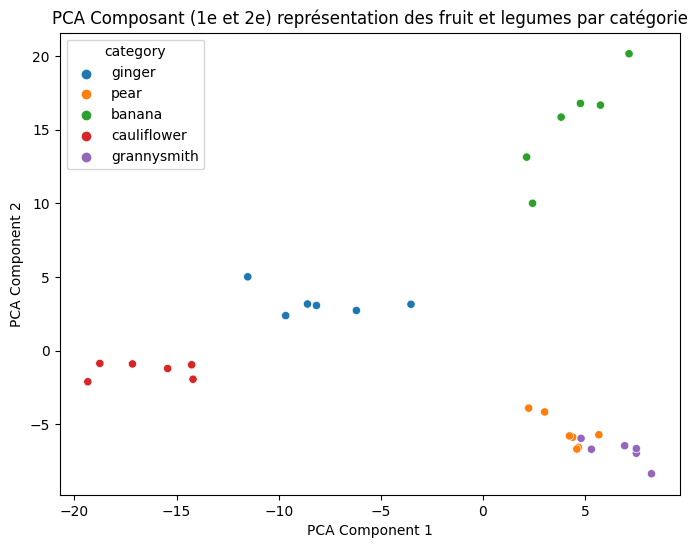

In [55]:
# tracer les composants pca et la dispersion des catégories avec seaborn

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sns.scatterplot(data=scatter_df, x='pca_comp_1', y='pca_comp_2', hue='category')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Composant (1e et 2e) représentation des fruit et legumes par catégorie')
plt.show()

# ENREGISTRER LES RÉSULTATS

In [56]:
# repartition et enrigistrer
src.select('category','pca_features').repartition(4) \
    .write.mode("overwrite") \
    .parquet(OUT_PARQUET)

# relire pour le verifier
spark.read.parquet(OUT_PARQUET).show()

+-----------+--------------------+
|   category|        pca_features|
+-----------+--------------------+
|       pear|[2.23535146332155...|
|     ginger|[-9.6574691666101...|
|cauliflower|[-14.193282966995...|
|     banana|[3.82578559401096...|
|     ginger|[-6.1957637665696...|
|     ginger|[-8.1513539169711...|
|grannysmith|[5.30652532840840...|
|grannysmith|[6.93497065373824...|
|cauliflower|[-17.157828426342...|
|grannysmith|[8.24643044467261...|
|     banana|[7.14839961720936...|
|       pear|[4.59375164779880...|
|cauliflower|[-19.341906774297...|
|grannysmith|[7.50387824185359...|
|       pear|[5.67096099856423...|
|       pear|[4.23186525692030...|
|grannysmith|[7.50715578628914...|
|       pear|[3.01696289634182...|
|cauliflower|[-14.259722031388...|
|     ginger|[-11.514528838734...|
+-----------+--------------------+
only showing top 20 rows



In [57]:
# Not sure if still needed
# apply acl to S3 bucket (but already done with permissions policy in S3 console)    
# ! aws s3api put-object-acl --acl public-read --bucket oc-p8-s3-adamphillips --key result/features.parquet/_SUCCESS

In [58]:
# stop the pyspark (spark) server (massive memory hog)
sc.stop()